In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import os
from PIL import Image
import math  # 添加 math 模块导入
import optuna  # 导入 Optuna

# 获取所有图像路径，递归查找
data = glob(r'/root/autodl-tmp/fingerprints/fingerprints/DB*/**/*.tif', recursive=True)
images = []


def readImages(data):
    for img_path in data:
        print(f"尝试读取图像: {img_path}")  # 打印图像路径
        try:
            img = Image.open(img_path)
            img = img.convert("RGB")  # 确保图像为 RGB 格式
            img = img.resize((224, 224))  # 调整图像尺寸
            images.append(np.array(img))  # 转换为 numpy 数组并添加到列表中
        except Exception as e:
            print(f"无法读取图像: {img_path}，错误信息: {e}")

    return images


# 读取图像
images = readImages(data)

# 检查是否成功读取任何图像
if len(images) == 0:
    raise ValueError("没有成功读取任何图像，请检查文件路径和格式。")

# 将图像数据转换为 float32 类型，并归一化到 [0, 1] 之间
images_arr = np.asarray(images).astype('float32') / 255.0

# 检查图像形状
print("图像形状:", images_arr.shape)

# 将图像的通道数从 (N, 224, 224, 3) 转换为 (N, 3, 224, 224) (PyTorch 使用通道优先格式)
if len(images_arr.shape) == 4:
    images_arr = np.transpose(images_arr, (0, 3, 1, 2))
else:
    raise ValueError("图像数组的形状不正确，检查读取步骤。")

# 划分训练集和验证集
train_X, valid_X, train_ground, valid_ground = train_test_split(images_arr, images_arr, test_size=0.2, random_state=13)

# 将数据转换为 PyTorch 张量
train_X = torch.tensor(train_X, dtype=torch.float32)
valid_X = torch.tensor(valid_X, dtype=torch.float32)

train_ground = torch.tensor(train_ground, dtype=torch.float32)
valid_ground = torch.tensor(valid_ground, dtype=torch.float32)

# 创建 PyTorch 数据加载器
train_dataset = TensorDataset(train_X, train_ground)
valid_dataset = TensorDataset(valid_X, valid_ground)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/108_6.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_1.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/108_7.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_2.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/108_8.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_3.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_1.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_4.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_3.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_5.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_2.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_6.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_4.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_7.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_5

In [2]:
# 定义 GELUB 激活函数（使用具体数值标记层）
class GELUB(nn.Module):
    def __init__(self, sigma):
        super().__init__()
        self.sigma = sigma

    def forward(self, input):
        return input * (1 + torch.erf(input / math.sqrt(2) / self.sigma)) / 2


# 定义自动编码器模型
class Autoencoder(nn.Module):
    def __init__(self, sigma_params):
        super(Autoencoder, self).__init__()

        # 编码器部分
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            GELUB(sigma_params['sigma_1']),  # 使用优化后的 sigma
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            GELUB(sigma_params['sigma_2']),  # 使用优化后的 sigma
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            GELUB(sigma_params['sigma_3'])  # 使用优化后的 sigma
        )

        # 解码器部分
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            GELUB(sigma_params['sigma_4']),  # 使用优化后的 sigma
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            GELUB(sigma_params['sigma_5']),  # 使用优化后的 sigma
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # 输出仍为 Sigmoid
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# 使用 GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 定义训练和验证函数
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=300):
    model.train()
    train_loss = []
    valid_loss = []

    for epoch in range(epochs):
        running_loss = 0.0
        for data in train_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)

            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # 计算训练集损失
        train_loss.append(running_loss / len(train_loader))

        # 计算验证集损失
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in valid_loader:
                inputs, targets = data
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        valid_loss.append(val_loss / len(valid_loader))
        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss[-1]:.4f}, Validation Loss: {valid_loss[-1]:.4f}")

    return train_loss, valid_loss


# Optuna 目标函数
def objective(trial):
    # 实例化自动编码器
    autoencoder = Autoencoder({
        'sigma_1': trial.suggest_float('sigma_1', 0, 6.0),
        'sigma_2': trial.suggest_float('sigma_2', 0, 6.0),
        'sigma_3': trial.suggest_float('sigma_3', 0, 6.0),
        'sigma_4': trial.suggest_float('sigma_4', 0, 6.0),
        'sigma_5': trial.suggest_float('sigma_5', 0, 6.0)
    }).to(device)

    # 定义损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

    # 训练模型
    train_loss, valid_loss = train_model(autoencoder, train_loader, valid_loader, criterion, optimizer, epochs=300)

    # 返回验证集最后的损失作为优化目标
    return valid_loss[-1]

In [3]:
# 使用 Optuna 优化
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# 获取最佳参数
best_params = study.best_params
print("最佳参数: ", best_params)

[I 2024-10-15 19:56:37,568] A new study created in memory with name: no-name-7d093252-e90e-4df1-8946-bbf94e4c16cf


Epoch 1/300, Training Loss: 0.0706, Validation Loss: 0.0688
Epoch 2/300, Training Loss: 0.0593, Validation Loss: 0.0562
Epoch 3/300, Training Loss: 0.0551, Validation Loss: 0.0508
Epoch 4/300, Training Loss: 0.0499, Validation Loss: 0.0504
Epoch 5/300, Training Loss: 0.0477, Validation Loss: 0.0428
Epoch 6/300, Training Loss: 0.0421, Validation Loss: 0.0373
Epoch 7/300, Training Loss: 0.0358, Validation Loss: 0.0328
Epoch 8/300, Training Loss: 0.0297, Validation Loss: 0.0245
Epoch 9/300, Training Loss: 0.0228, Validation Loss: 0.0210
Epoch 10/300, Training Loss: 0.0208, Validation Loss: 0.0226
Epoch 11/300, Training Loss: 0.0212, Validation Loss: 0.0240
Epoch 12/300, Training Loss: 0.0216, Validation Loss: 0.0233
Epoch 13/300, Training Loss: 0.0197, Validation Loss: 0.0198
Epoch 14/300, Training Loss: 0.0180, Validation Loss: 0.0185
Epoch 15/300, Training Loss: 0.0174, Validation Loss: 0.0179
Epoch 16/300, Training Loss: 0.0170, Validation Loss: 0.0186
Epoch 17/300, Training Loss: 0.01

[I 2024-10-15 19:59:25,939] Trial 0 finished with value: 0.004578076768666506 and parameters: {'sigma_1': 5.472502782202021, 'sigma_2': 2.4615253050820787, 'sigma_3': 3.903663829093426, 'sigma_4': 3.0635164582312004, 'sigma_5': 1.517705986175849}. Best is trial 0 with value: 0.004578076768666506.


Epoch 300/300, Training Loss: 0.0041, Validation Loss: 0.0046
Epoch 1/300, Training Loss: 0.0687, Validation Loss: 0.0668
Epoch 2/300, Training Loss: 0.0594, Validation Loss: 0.0581
Epoch 3/300, Training Loss: 0.0551, Validation Loss: 0.0512
Epoch 4/300, Training Loss: 0.0516, Validation Loss: 0.0528
Epoch 5/300, Training Loss: 0.0489, Validation Loss: 0.0441
Epoch 6/300, Training Loss: 0.0436, Validation Loss: 0.0415
Epoch 7/300, Training Loss: 0.0389, Validation Loss: 0.0357
Epoch 8/300, Training Loss: 0.0328, Validation Loss: 0.0279
Epoch 9/300, Training Loss: 0.0229, Validation Loss: 0.0193
Epoch 10/300, Training Loss: 0.0174, Validation Loss: 0.0224
Epoch 11/300, Training Loss: 0.0223, Validation Loss: 0.0240
Epoch 12/300, Training Loss: 0.0217, Validation Loss: 0.0194
Epoch 13/300, Training Loss: 0.0166, Validation Loss: 0.0176
Epoch 14/300, Training Loss: 0.0161, Validation Loss: 0.0194
Epoch 15/300, Training Loss: 0.0179, Validation Loss: 0.0195
Epoch 16/300, Training Loss: 0.0

[I 2024-10-15 20:02:11,893] Trial 1 finished with value: 0.004431008826941252 and parameters: {'sigma_1': 1.8411205716687609, 'sigma_2': 5.8069239687786665, 'sigma_3': 4.94227889895968, 'sigma_4': 4.882651852401122, 'sigma_5': 5.32397590332404}. Best is trial 1 with value: 0.004431008826941252.


Epoch 300/300, Training Loss: 0.0040, Validation Loss: 0.0044
Epoch 1/300, Training Loss: 0.0698, Validation Loss: 0.0675
Epoch 2/300, Training Loss: 0.0575, Validation Loss: 0.0597
Epoch 3/300, Training Loss: 0.0553, Validation Loss: 0.0502
Epoch 4/300, Training Loss: 0.0473, Validation Loss: 0.0409
Epoch 5/300, Training Loss: 0.0391, Validation Loss: 0.0327
Epoch 6/300, Training Loss: 0.0308, Validation Loss: 0.0257
Epoch 7/300, Training Loss: 0.0248, Validation Loss: 0.0200
Epoch 8/300, Training Loss: 0.0223, Validation Loss: 0.0281
Epoch 9/300, Training Loss: 0.0271, Validation Loss: 0.0226
Epoch 10/300, Training Loss: 0.0235, Validation Loss: 0.0205
Epoch 11/300, Training Loss: 0.0191, Validation Loss: 0.0215
Epoch 12/300, Training Loss: 0.0198, Validation Loss: 0.0195
Epoch 13/300, Training Loss: 0.0188, Validation Loss: 0.0208
Epoch 14/300, Training Loss: 0.0178, Validation Loss: 0.0179
Epoch 15/300, Training Loss: 0.0164, Validation Loss: 0.0189
Epoch 16/300, Training Loss: 0.0

[I 2024-10-15 20:04:57,527] Trial 2 finished with value: 0.005358986556529999 and parameters: {'sigma_1': 3.2679502817071606, 'sigma_2': 4.192595757127851, 'sigma_3': 0.05753725760870787, 'sigma_4': 0.5395228694607364, 'sigma_5': 0.4108700245976098}. Best is trial 1 with value: 0.004431008826941252.


Epoch 300/300, Training Loss: 0.0048, Validation Loss: 0.0054
Epoch 1/300, Training Loss: 0.0699, Validation Loss: 0.0684
Epoch 2/300, Training Loss: 0.0592, Validation Loss: 0.0538
Epoch 3/300, Training Loss: 0.0523, Validation Loss: 0.0472
Epoch 4/300, Training Loss: 0.0466, Validation Loss: 0.0433
Epoch 5/300, Training Loss: 0.0396, Validation Loss: 0.0353
Epoch 6/300, Training Loss: 0.0321, Validation Loss: 0.0267
Epoch 7/300, Training Loss: 0.0255, Validation Loss: 0.0192
Epoch 8/300, Training Loss: 0.0193, Validation Loss: 0.0197
Epoch 9/300, Training Loss: 0.0200, Validation Loss: 0.0245
Epoch 10/300, Training Loss: 0.0215, Validation Loss: 0.0232
Epoch 11/300, Training Loss: 0.0208, Validation Loss: 0.0199
Epoch 12/300, Training Loss: 0.0190, Validation Loss: 0.0196
Epoch 13/300, Training Loss: 0.0182, Validation Loss: 0.0188
Epoch 14/300, Training Loss: 0.0181, Validation Loss: 0.0185
Epoch 15/300, Training Loss: 0.0172, Validation Loss: 0.0184
Epoch 16/300, Training Loss: 0.0

[I 2024-10-15 20:07:42,137] Trial 3 finished with value: 0.004116634838283062 and parameters: {'sigma_1': 0.5167301783834592, 'sigma_2': 2.572497451840294, 'sigma_3': 3.8850246355170235, 'sigma_4': 1.3906086044177144, 'sigma_5': 1.1024465104180514}. Best is trial 3 with value: 0.004116634838283062.


Epoch 300/300, Training Loss: 0.0036, Validation Loss: 0.0041
Epoch 1/300, Training Loss: 0.0696, Validation Loss: 0.0657
Epoch 2/300, Training Loss: 0.0566, Validation Loss: 0.0711
Epoch 3/300, Training Loss: 0.0614, Validation Loss: 0.0521
Epoch 4/300, Training Loss: 0.0534, Validation Loss: 0.0611
Epoch 5/300, Training Loss: 0.0576, Validation Loss: 0.0571
Epoch 6/300, Training Loss: 0.0520, Validation Loss: 0.0457
Epoch 7/300, Training Loss: 0.0447, Validation Loss: 0.0468
Epoch 8/300, Training Loss: 0.0458, Validation Loss: 0.0384
Epoch 9/300, Training Loss: 0.0382, Validation Loss: 0.0399
Epoch 10/300, Training Loss: 0.0366, Validation Loss: 0.0290
Epoch 11/300, Training Loss: 0.0273, Validation Loss: 0.0243
Epoch 12/300, Training Loss: 0.0209, Validation Loss: 0.0242
Epoch 13/300, Training Loss: 0.0192, Validation Loss: 0.0219
Epoch 14/300, Training Loss: 0.0195, Validation Loss: 0.0235
Epoch 15/300, Training Loss: 0.0203, Validation Loss: 0.0208
Epoch 16/300, Training Loss: 0.0

[I 2024-10-15 20:10:24,590] Trial 4 finished with value: 0.0055113728158175945 and parameters: {'sigma_1': 4.0359753340823845, 'sigma_2': 0.4401934022804894, 'sigma_3': 1.4790622193922327, 'sigma_4': 4.416423910142509, 'sigma_5': 1.563390570941146}. Best is trial 3 with value: 0.004116634838283062.


Epoch 300/300, Training Loss: 0.0049, Validation Loss: 0.0055
Epoch 1/300, Training Loss: 0.0695, Validation Loss: 0.0699
Epoch 2/300, Training Loss: 0.0613, Validation Loss: 0.0485
Epoch 3/300, Training Loss: 0.0507, Validation Loss: 0.0432
Epoch 4/300, Training Loss: 0.0433, Validation Loss: 0.0445
Epoch 5/300, Training Loss: 0.0401, Validation Loss: 0.0316
Epoch 6/300, Training Loss: 0.0305, Validation Loss: 0.0258
Epoch 7/300, Training Loss: 0.0231, Validation Loss: 0.0229
Epoch 8/300, Training Loss: 0.0207, Validation Loss: 0.0190
Epoch 9/300, Training Loss: 0.0193, Validation Loss: 0.0233
Epoch 10/300, Training Loss: 0.0214, Validation Loss: 0.0224
Epoch 11/300, Training Loss: 0.0193, Validation Loss: 0.0187
Epoch 12/300, Training Loss: 0.0174, Validation Loss: 0.0186
Epoch 13/300, Training Loss: 0.0178, Validation Loss: 0.0188
Epoch 14/300, Training Loss: 0.0177, Validation Loss: 0.0185
Epoch 15/300, Training Loss: 0.0168, Validation Loss: 0.0175
Epoch 16/300, Training Loss: 0.0

[I 2024-10-15 20:13:07,347] Trial 5 finished with value: 0.004076406825333834 and parameters: {'sigma_1': 0.5188177719667197, 'sigma_2': 3.9898707998273615, 'sigma_3': 4.295444135052868, 'sigma_4': 2.8040035846084304, 'sigma_5': 1.1312840835526206}. Best is trial 5 with value: 0.004076406825333834.


Epoch 300/300, Training Loss: 0.0036, Validation Loss: 0.0041
Epoch 1/300, Training Loss: 0.0689, Validation Loss: 0.0664
Epoch 2/300, Training Loss: 0.0593, Validation Loss: 0.0594
Epoch 3/300, Training Loss: 0.0548, Validation Loss: 0.0517
Epoch 4/300, Training Loss: 0.0517, Validation Loss: 0.0537
Epoch 5/300, Training Loss: 0.0490, Validation Loss: 0.0414
Epoch 6/300, Training Loss: 0.0405, Validation Loss: 0.0402
Epoch 7/300, Training Loss: 0.0366, Validation Loss: 0.0318
Epoch 8/300, Training Loss: 0.0322, Validation Loss: 0.0267
Epoch 9/300, Training Loss: 0.0223, Validation Loss: 0.0225
Epoch 10/300, Training Loss: 0.0188, Validation Loss: 0.0251
Epoch 11/300, Training Loss: 0.0217, Validation Loss: 0.0239
Epoch 12/300, Training Loss: 0.0218, Validation Loss: 0.0190
Epoch 13/300, Training Loss: 0.0177, Validation Loss: 0.0203
Epoch 14/300, Training Loss: 0.0178, Validation Loss: 0.0180
Epoch 15/300, Training Loss: 0.0175, Validation Loss: 0.0195
Epoch 16/300, Training Loss: 0.0

[I 2024-10-15 20:15:50,212] Trial 6 finished with value: 0.004283726681023836 and parameters: {'sigma_1': 1.8215464110320068, 'sigma_2': 0.40407261674709494, 'sigma_3': 3.800314256462835, 'sigma_4': 1.0027751020021147, 'sigma_5': 4.474368182420953}. Best is trial 5 with value: 0.004076406825333834.


Epoch 300/300, Training Loss: 0.0039, Validation Loss: 0.0043
Epoch 1/300, Training Loss: 0.0700, Validation Loss: 0.0690
Epoch 2/300, Training Loss: 0.0598, Validation Loss: 0.0587
Epoch 3/300, Training Loss: 0.0567, Validation Loss: 0.0525
Epoch 4/300, Training Loss: 0.0519, Validation Loss: 0.0535
Epoch 5/300, Training Loss: 0.0498, Validation Loss: 0.0446
Epoch 6/300, Training Loss: 0.0442, Validation Loss: 0.0422
Epoch 7/300, Training Loss: 0.0406, Validation Loss: 0.0387
Epoch 8/300, Training Loss: 0.0365, Validation Loss: 0.0305
Epoch 9/300, Training Loss: 0.0285, Validation Loss: 0.0226
Epoch 10/300, Training Loss: 0.0222, Validation Loss: 0.0194
Epoch 11/300, Training Loss: 0.0188, Validation Loss: 0.0270
Epoch 12/300, Training Loss: 0.0215, Validation Loss: 0.0245
Epoch 13/300, Training Loss: 0.0206, Validation Loss: 0.0226
Epoch 14/300, Training Loss: 0.0187, Validation Loss: 0.0181
Epoch 15/300, Training Loss: 0.0174, Validation Loss: 0.0184
Epoch 16/300, Training Loss: 0.0

[I 2024-10-15 20:18:36,232] Trial 7 finished with value: 0.005211109295487404 and parameters: {'sigma_1': 3.9818546198046967, 'sigma_2': 5.375977639719819, 'sigma_3': 0.642348901063144, 'sigma_4': 1.9605896682214725, 'sigma_5': 4.102857651838898}. Best is trial 5 with value: 0.004076406825333834.


Epoch 300/300, Training Loss: 0.0046, Validation Loss: 0.0052
Epoch 1/300, Training Loss: 0.0706, Validation Loss: 0.0705
Epoch 2/300, Training Loss: 0.0623, Validation Loss: 0.0540
Epoch 3/300, Training Loss: 0.0578, Validation Loss: 0.0491
Epoch 4/300, Training Loss: 0.0502, Validation Loss: 0.0555
Epoch 5/300, Training Loss: 0.0519, Validation Loss: 0.0449
Epoch 6/300, Training Loss: 0.0409, Validation Loss: 0.0433
Epoch 7/300, Training Loss: 0.0403, Validation Loss: 0.0335
Epoch 8/300, Training Loss: 0.0357, Validation Loss: 0.0332
Epoch 9/300, Training Loss: 0.0306, Validation Loss: 0.0309
Epoch 10/300, Training Loss: 0.0292, Validation Loss: 0.0238
Epoch 11/300, Training Loss: 0.0255, Validation Loss: 0.0232
Epoch 12/300, Training Loss: 0.0217, Validation Loss: 0.0228
Epoch 13/300, Training Loss: 0.0204, Validation Loss: 0.0235
Epoch 14/300, Training Loss: 0.0206, Validation Loss: 0.0201
Epoch 15/300, Training Loss: 0.0196, Validation Loss: 0.0184
Epoch 16/300, Training Loss: 0.0

[I 2024-10-15 20:21:21,682] Trial 8 finished with value: 0.004606626462191343 and parameters: {'sigma_1': 3.5590883353934784, 'sigma_2': 3.1100883798227827, 'sigma_3': 0.9623860780158198, 'sigma_4': 0.6271089534442023, 'sigma_5': 0.6679854658314996}. Best is trial 5 with value: 0.004076406825333834.


Epoch 300/300, Training Loss: 0.0041, Validation Loss: 0.0046
Epoch 1/300, Training Loss: 0.0704, Validation Loss: 0.0678
Epoch 2/300, Training Loss: 0.0597, Validation Loss: 0.0577
Epoch 3/300, Training Loss: 0.0537, Validation Loss: 0.0482
Epoch 4/300, Training Loss: 0.0491, Validation Loss: 0.0480
Epoch 5/300, Training Loss: 0.0427, Validation Loss: 0.0388
Epoch 6/300, Training Loss: 0.0379, Validation Loss: 0.0302
Epoch 7/300, Training Loss: 0.0308, Validation Loss: 0.0287
Epoch 8/300, Training Loss: 0.0270, Validation Loss: 0.0256
Epoch 9/300, Training Loss: 0.0241, Validation Loss: 0.0232
Epoch 10/300, Training Loss: 0.0227, Validation Loss: 0.0202
Epoch 11/300, Training Loss: 0.0205, Validation Loss: 0.0203
Epoch 12/300, Training Loss: 0.0199, Validation Loss: 0.0220
Epoch 13/300, Training Loss: 0.0190, Validation Loss: 0.0201
Epoch 14/300, Training Loss: 0.0176, Validation Loss: 0.0180
Epoch 15/300, Training Loss: 0.0167, Validation Loss: 0.0184
Epoch 16/300, Training Loss: 0.0

[I 2024-10-15 20:24:06,035] Trial 9 finished with value: 0.004367820918560028 and parameters: {'sigma_1': 2.669891522691885, 'sigma_2': 5.817038964627804, 'sigma_3': 2.9691656169743834, 'sigma_4': 0.5119731407240762, 'sigma_5': 0.4129770367751162}. Best is trial 5 with value: 0.004076406825333834.


Epoch 300/300, Training Loss: 0.0039, Validation Loss: 0.0044
最佳参数:  {'sigma_1': 0.5188177719667197, 'sigma_2': 3.9898707998273615, 'sigma_3': 4.295444135052868, 'sigma_4': 2.8040035846084304, 'sigma_5': 1.1312840835526206}


In [4]:

# 使用最佳参数重新训练模型
autoencoder = Autoencoder(best_params).to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# 重新训练模型
train_loss, valid_loss = train_model(autoencoder, train_loader, valid_loader, criterion, optimizer, epochs=300)

Epoch 1/300, Training Loss: 0.0703, Validation Loss: 0.0665
Epoch 2/300, Training Loss: 0.0557, Validation Loss: 0.0684
Epoch 3/300, Training Loss: 0.0591, Validation Loss: 0.0495
Epoch 4/300, Training Loss: 0.0508, Validation Loss: 0.0581
Epoch 5/300, Training Loss: 0.0546, Validation Loss: 0.0523
Epoch 6/300, Training Loss: 0.0473, Validation Loss: 0.0410
Epoch 7/300, Training Loss: 0.0414, Validation Loss: 0.0424
Epoch 8/300, Training Loss: 0.0391, Validation Loss: 0.0323
Epoch 9/300, Training Loss: 0.0317, Validation Loss: 0.0331
Epoch 10/300, Training Loss: 0.0285, Validation Loss: 0.0211
Epoch 11/300, Training Loss: 0.0204, Validation Loss: 0.0194
Epoch 12/300, Training Loss: 0.0181, Validation Loss: 0.0255
Epoch 13/300, Training Loss: 0.0211, Validation Loss: 0.0220
Epoch 14/300, Training Loss: 0.0207, Validation Loss: 0.0197
Epoch 15/300, Training Loss: 0.0180, Validation Loss: 0.0209
Epoch 16/300, Training Loss: 0.0190, Validation Loss: 0.0184
Epoch 17/300, Training Loss: 0.01

In [1]:
import pickle

# 指定损失数据文件的路径
loss_data_path = r'D:/PycharmProjects/保存的参数/指纹参数/loss_data(gelu).pkl'

# 直接加载损失数据
with open(loss_data_path, 'rb') as f:
    loss_data = pickle.load(f)

# 获取训练和验证损失
train_loss = loss_data['train_loss']
valid_loss = loss_data['valid_loss']

print("损失数据已成功加载。")



损失数据已成功加载。


Failed to find a Ghostscript installation.  Distillation step skipped.


损失图已保存到 D:\PycharmProjects\保存的参数\指纹参数\loss_gelu.eps


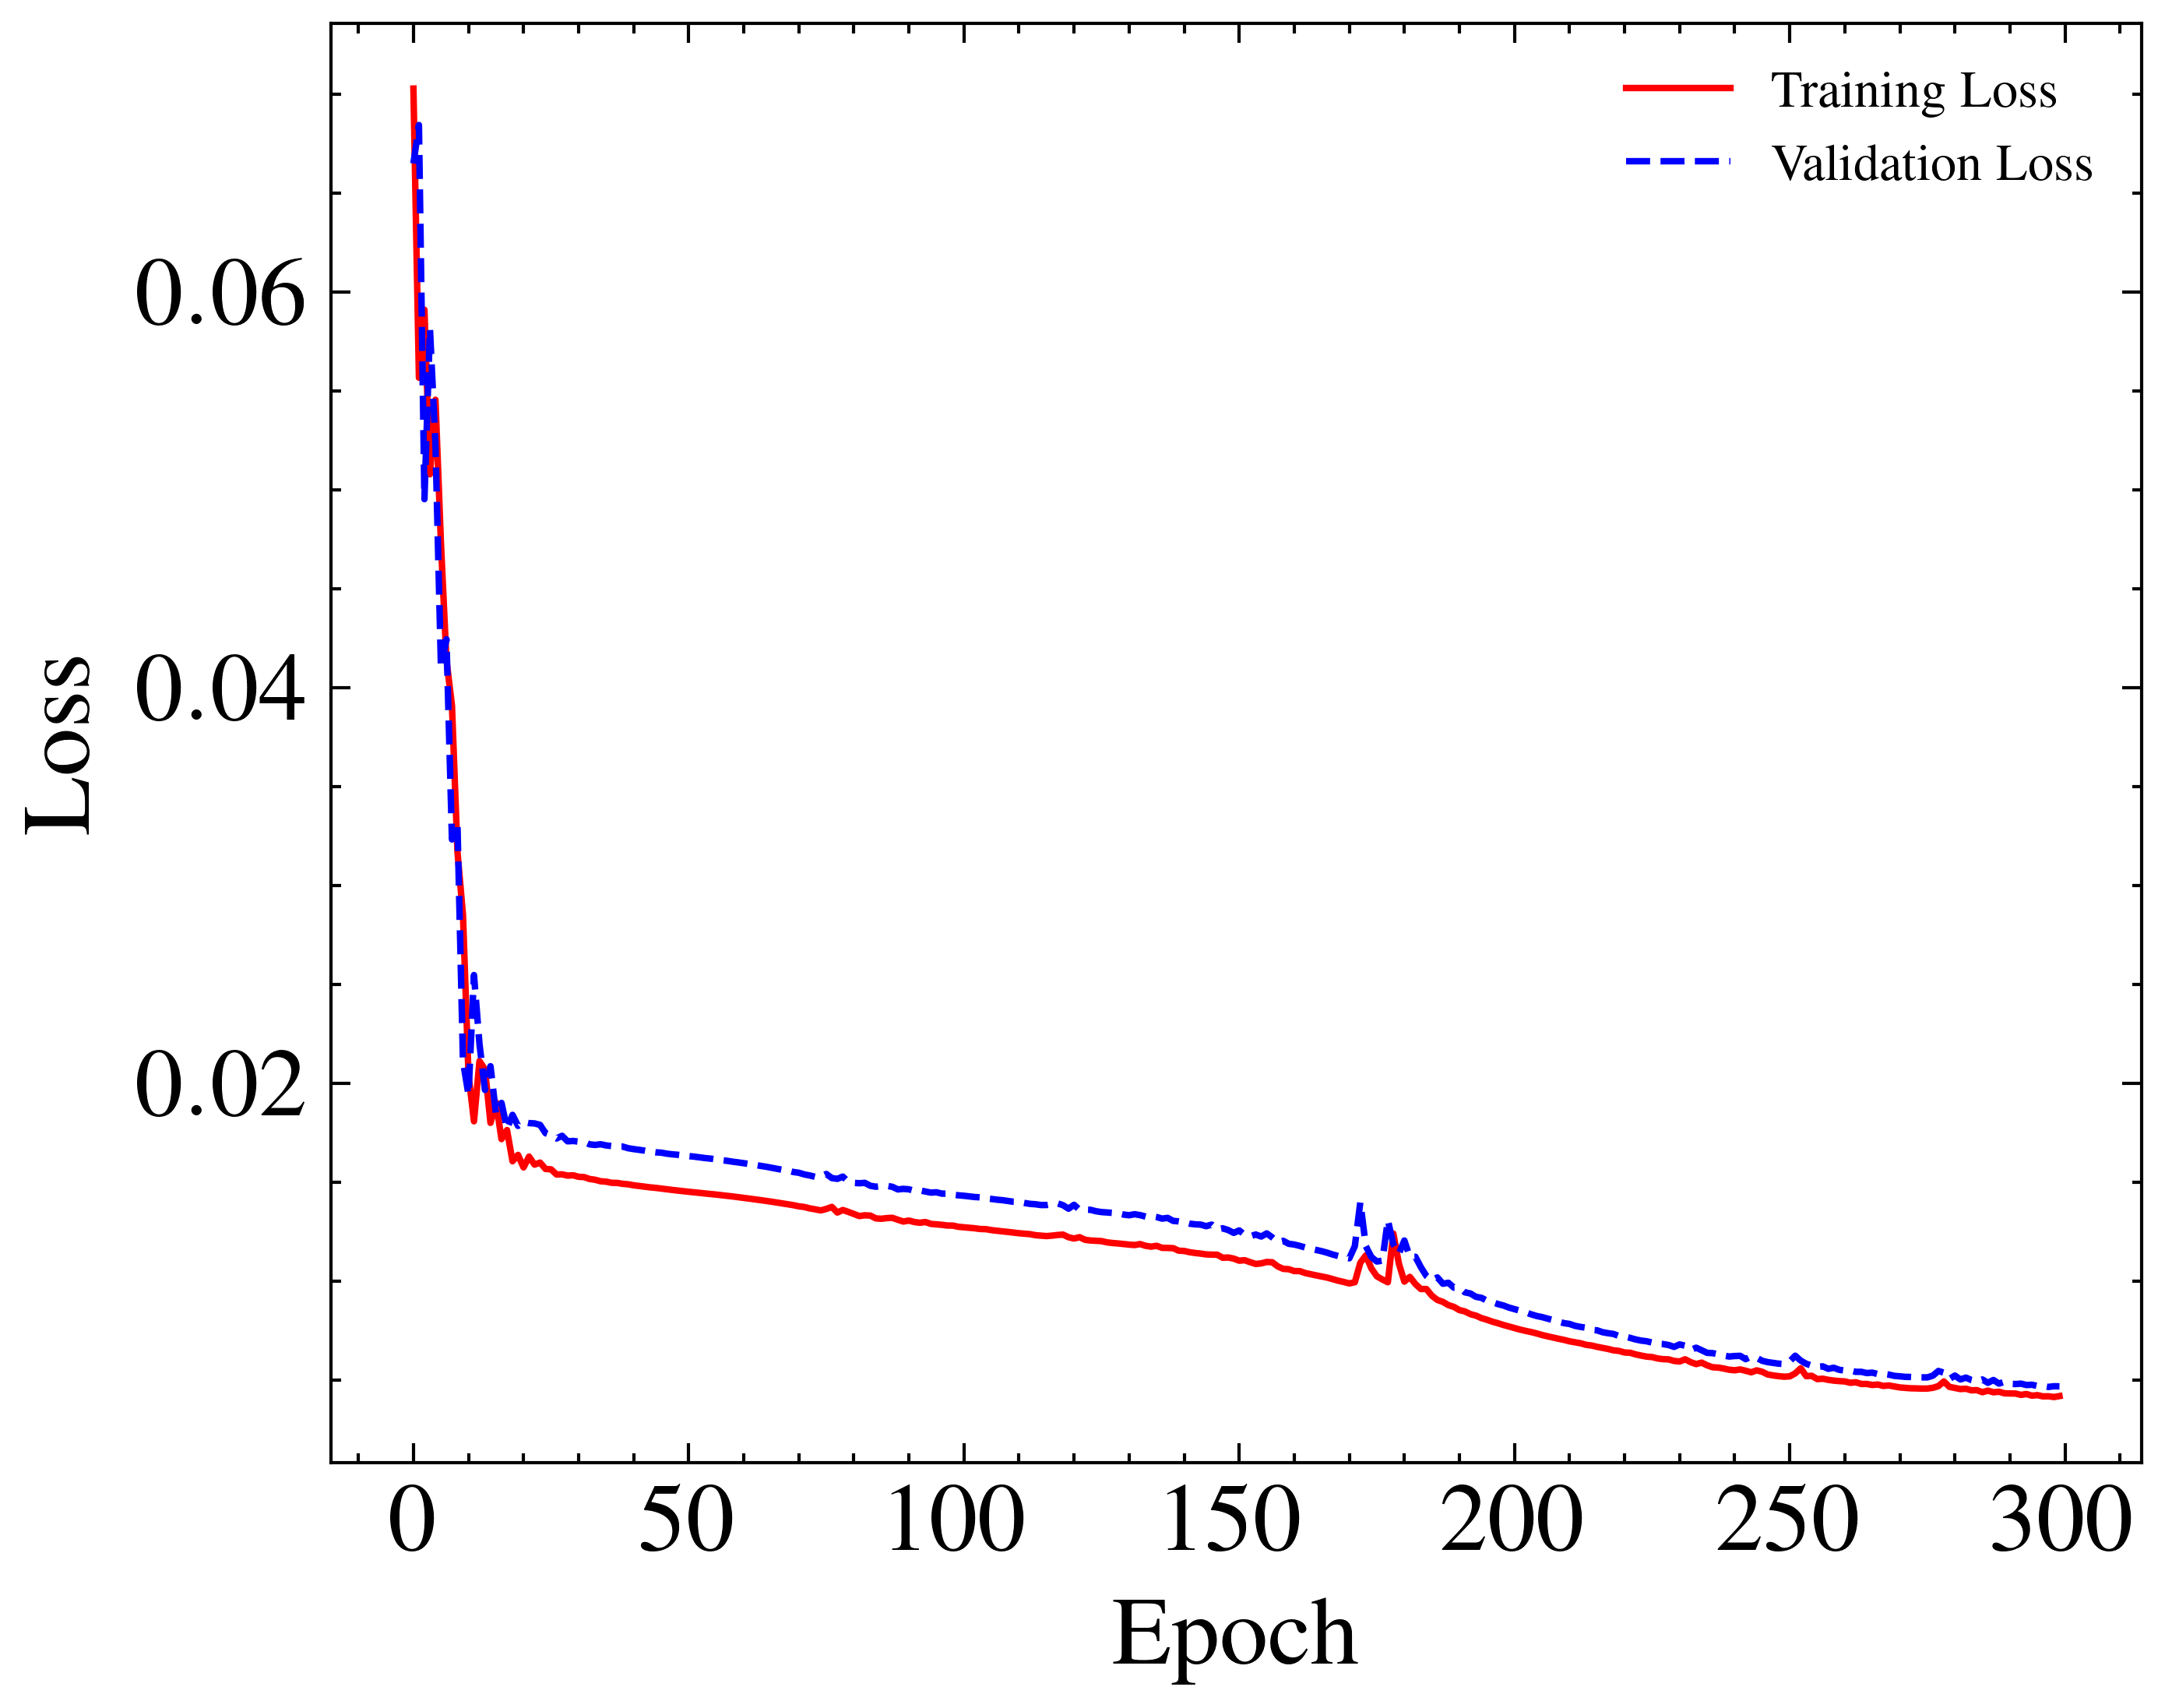

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots

# 配置绘图样式和参数
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = True
plt.style.use(['science', 'ieee'])
plt.rcParams['text.usetex'] = True

# 创建图形和坐标轴
fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()  # 清除现有内容
plt.tick_params(labelsize=15)  # 设置刻度字体大小

# 绘制损失曲线（红色和蓝色）
ax.plot(np.arange(len(train_loss)), train_loss, color='red', label='Training Loss', linewidth=1)
ax.plot(np.arange(len(valid_loss)), valid_loss, color='blue', label='Validation Loss', linewidth=1)

# 设置正体的轴标签
ax.set_xlabel(r'$\mathrm{Epoch}$', fontsize=15)
ax.set_ylabel(r'$\mathrm{Loss}$', fontsize=15)

# 手动设置x轴刻度
plt.xticks(np.arange(0, len(train_loss) + 5, step=50))

# 添加图例（标注）
plt.legend(fontsize=8, loc='upper right')

# 指定保存路径和文件名
plot_path = r'D:\PycharmProjects\保存的参数\指纹参数\loss_gelu.eps'

# 保存为 EPS 文件
plt.savefig(plot_path, format='eps', bbox_inches='tight')
print(f"损失图已保存到 {plot_path}")

# 展示损失图
plt.show()

所有图像已保存至: ./geluPics/


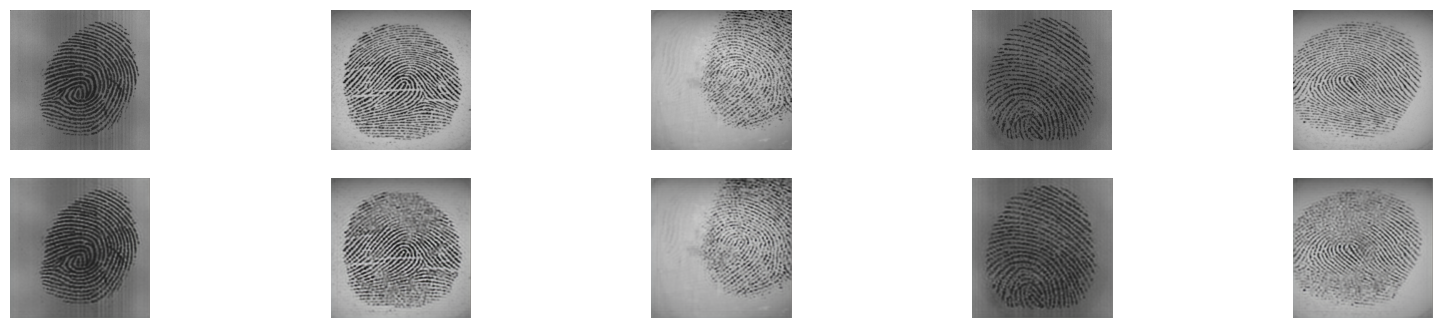

In [8]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def save_and_visualize_reconstructions(model, data_loader, save_dir):
    """
    将所有验证集图像的原始和重建图像保存到指定文件夹，并展示前 5 张的对比。
    参数：
    - model: Autoencoder 模型
    - data_loader: 验证集的数据加载器
    - save_dir: 保存图像的文件夹路径（你需要提前创建好）
    """
    # 切换到评估模式
    model.eval()
    os.makedirs(save_dir, exist_ok=True)  # 如果文件夹不存在则创建
    img_counter = 0  # 图像计数器

    with torch.no_grad():
        # 遍历验证集批次
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            # 将张量转换为 NumPy 格式，并缩放到 [0, 255]
            inputs = (inputs.cpu().numpy() * 255).astype(np.uint8)
            outputs = (outputs.cpu().numpy() * 255).astype(np.uint8)

            # 遍历批次中的每一张图像
            for i in range(inputs.shape[0]):
                # 转换为 (H, W, C) 格式（适用于 PIL）
                original_img = np.transpose(inputs[i], (1, 2, 0))
                reconstructed_img = np.transpose(outputs[i], (1, 2, 0))

                # 保存原始和重建图像
                original_path = os.path.join(save_dir, f"original_{img_counter}.png")
                reconstructed_path = os.path.join(save_dir, f"reconstructed_{img_counter}.png")
                
                Image.fromarray(original_img).save(original_path)
                Image.fromarray(reconstructed_img).save(reconstructed_path)

                img_counter += 1  # 更新计数器

    print(f"所有图像已保存至: {save_dir}")

    # 展示前 5 张原始和重建图像的对比
    plt.figure(figsize=(20, 4))
    for i in range(5):
        # 加载已保存的图像
        original_img = Image.open(os.path.join(save_dir, f"original_{i}.png"))
        reconstructed_img = Image.open(os.path.join(save_dir, f"reconstructed_{i}.png"))

        # 显示原始图像
        plt.subplot(2, 5, i + 1)
        plt.imshow(original_img)
        plt.axis('off')

        # 显示重建图像
        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructed_img)
        plt.axis('off')

    plt.show()

# 使用你指定的文件夹路径保存和展示重建图像
save_dir ="./geluPics/"  # 将此处替换为你创建的文件夹路径
save_and_visualize_reconstructions(autoencoder, valid_loader, save_dir)

In [9]:
import shutil

# 指定要压缩的文件夹和输出路径
folder_to_zip = "./geluPics"  # 已存在的文件夹路径
zip_output_path = "./geluPics.zip"  # 输出的 ZIP 文件路径

# 压缩文件夹
shutil.make_archive(zip_output_path.replace('.zip', ''), 'zip', folder_to_zip)

print(f"文件夹已成功压缩为: {zip_output_path}")


文件夹已成功压缩为: ./geluPics.zip
